<a href="https://colab.research.google.com/github/aleespejo12/SistemaDeControl2/blob/main/TP2_SCII_Alejandro_Espejo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerías


In [ ]:
!pip install -U control qtpy;
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
# import math
import matplotlib.pyplot as plt
import control as ctrl
import control as ct
from control.matlab import * #permite escribir igual que en Matlab
import cmath as cm
from scipy import signal
from scipy.signal import lti
from sympy import symbols, simplify


#Actividad Práctica Nº2:
Diseño de controladores considerando la
dinámica del error y la magnitud de la acción de control en sistemas
no lineales multivariables

#Caso de Estudio 1

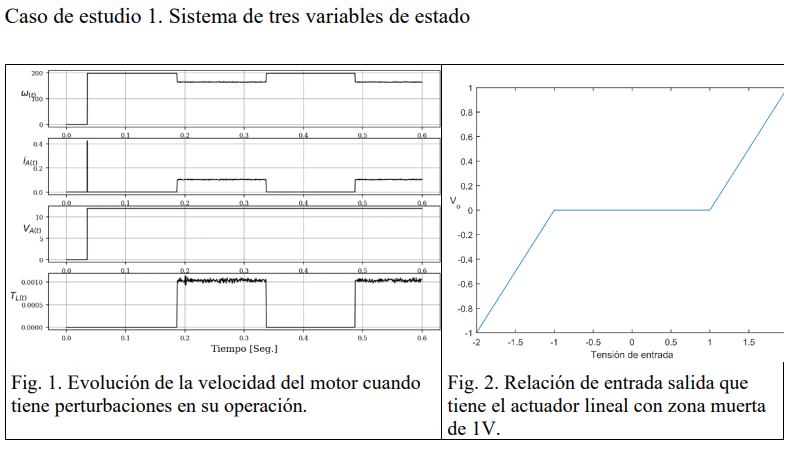

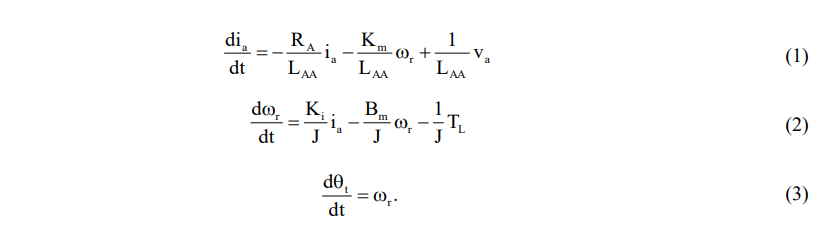

###ITEM [1]
Implementar un sistema en variables de estado que controle el ángulo del motor, para
consignas de Pi/2 y –Pi/2 cambiando cada 5 segundos y que el TL es el descripto en la planilla de datos
comparando el desempeño con el obtenido con el PID digital del TP Nº1. Hallar el valor de
integración Euler adecuado.
Objetivo: acelerar la dinámica del controlador verificando el resultado con las curvas del archivo xlsx
adjunto.
-Evitando que la tensión supere los 24Volts en valor absoluto, especificar el tiempo de muestreo
necesario para el controlador cumpla el objetivo.
-Asumiendo que no puede medirse directamente la corriente, pero sí la velocidad y el ángulo,
proponer un controlador que logre el objetivo.
-Determinar el efecto de la nolinealidad en la acción de control, descripta en la Fig. 2, y verificar cuál
es el máximo valor admisible de ésa no linealidad.

Definimos el sistema en Variables de Estado

In [ ]:
# Parámetros del motor
Ki = 16.52
Laa = 0.00046850605031778677
Ra = 28.130821798557065
J = 1.9551508446447576e-06
Km = 0.06053268765133172
Bm = 0

# Matrices del sistema
A = np.array([
    [-Ra/Laa, -Km/Laa, 0],
    [Ki/J, -Bm/J, 0],
    [0, 1, 0]
])
B = np.array([
    [1/Laa],
    [0],
    [0]
])
C = np.array([
    [0, 0, 1]
])
D = np.array([
    [0]
])


sys = signal.StateSpace(A, B, C,D)
tf = signal.StateSpace.to_tf(sys)
print("Función de transferencia:")
print(tf)


Función de transferencia:
TransferFunctionContinuous(
array([-1.45519152e-11, -4.76837158e-07,  1.80349345e+10]),
array([1.00000000e+00, 6.00436681e+04, 1.09170306e+09, 0.00000000e+00]),
dt: None
)


In [ ]:
# Calcular la matriz de observabilidad
def observability_matrix(A, C):
    n = A.shape[0]
    O = C
    for i in range(1, n):
        O = np.vstack((O, np.dot(C, np.linalg.matrix_power(A, i))))
    return O

O = observability_matrix(A, C)
print("Matriz de observabilidad:")
print(O)
# Calcular el rango de la matriz de observabilidad
rank_O = np.linalg.matrix_rank(O)
print("Rango de la matriz de observabilidad:", rank_O)

# Verificar si el sistema es observable
n_states = A.shape[0]
if rank_O == n_states:
    print("El sistema es observable")
else:
    print("El sistema no es observable")

Matriz de observabilidad:
[[0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [8.44947593e+06 0.00000000e+00 0.00000000e+00]]
Rango de la matriz de observabilidad: 3
El sistema es observable


In [ ]:
# Calcular la matriz de controlabilidad
def controllability_matrix(A, B):
    n = A.shape[0]
    C = B
    for i in range(1, n):
        C = np.hstack((C, np.dot(A, np.linalg.matrix_power(A, i-1) @ B)))
    return C

cont_matrix = controllability_matrix(A, B)
print("Matriz de controlabilidad:")
print(cont_matrix)

# Calcular el rango
rank_cont = np.linalg.matrix_rank(cont_matrix)
print("Rango de la matriz de controlabilidad:", rank_cont)
n_states = A.shape[0]

# Verificar controlabilidad
if rank_cont == n_states:
    print("El sistema es controlable")
else:
    print("El sistema no es controlable")

Matriz de controlabilidad:
[[ 2.13444415e+03 -1.28159856e+08  5.36500868e+12]
 [ 0.00000000e+00  1.80349345e+10 -1.08288362e+15]
 [ 0.00000000e+00  0.00000000e+00  1.80349345e+10]]
Rango de la matriz de controlabilidad: 3
El sistema es controlable


In [ ]:
# Calcular los valores propios de la matriz A
eigenvalues = np.linalg.eigvals(A)
print("Valores propios de A:", eigenvalues)

# Calcular la mayor magnitud de los valores propios
max_eigenvalue_magnitude = np.max(np.abs(eigenvalues))
print("Mayor magnitud de los valores propios:", max_eigenvalue_magnitude)

# Seleccionar el paso de tiempo Δt (por ejemplo, 1/10 de la inversa de la mayor magnitud)
dt = 1 / (10 * max_eigenvalue_magnitude)
print("Paso de tiempo de integración (Δt):", dt)

Valores propios de A: [     0.            +0.j         -30021.83406114+13798.28019625j
 -30021.83406114-13798.28019625j]
Mayor magnitud de los valores propios: 33040.930022754495
Paso de tiempo de integración (Δt): 3.0265491900843104e-06


In [ ]:
# Calcular la transformación a la forma canónica controlable
T = cont_matrix
A_canonical = np.linalg.inv(T) @ A @ T
B_canonical = np.linalg.inv(T) @ B
C_canonical = C @ T

print("Forma canónica controlable A:")
print(A_canonical)
print("Forma canónica controlable B:")
print(B_canonical)
print("Forma canónica controlable C:")
print(C_canonical)

# Elegir los polos deseados
desired_poles = np.array([-1000, -2000, -3000])

# Calcular la ganancia del controlador usando el método de Ackermann
def ackermann(A, B, desired_poles):
    n = A.shape[0]
    A_coeffs = np.poly(A)
    desired_coeffs = np.poly(desired_poles)
    phi_A = np.zeros((n, n))
    for i in range(n):
        phi_A += (desired_coeffs[i] - A_coeffs[i]) * np.linalg.matrix_power(A, n-1-i)
    K = np.linalg.inv(cont_matrix) @ phi_A @ np.linalg.inv(cont_matrix) @ B
    return K.T

K = ackermann(A, B, desired_poles)
print("Ganancia del controlador K:")
print(K)

Forma canónica controlable A:
[[ 2.92308353e-12 -1.75512657e-07  7.34728452e-03]
 [ 1.00000000e+00  2.20461830e-13 -1.09170306e+09]
 [ 0.00000000e+00  1.00000000e+00 -6.00436681e+04]]
Forma canónica controlable B:
[[1.]
 [0.]
 [0.]]
Forma canónica controlable C:
[[0.00000000e+00 0.00000000e+00 1.80349345e+10]]
Ganancia del controlador K:
[[-5.06315921e+05 -2.53197855e+01  0.00000000e+00]]


In [ ]:

# Definir las matrices de ponderación Q y R
Q = np.diag([1, 1, 10])  # Pondera más el tercer estado
R = np.array([[0.01]])   # Penaliza menos la entrada



# Calcular la matriz de ganancias del controlador LQR
K, S, E = ct.lqr(A, B, Q, R)


print("Matriz de ganancias del controlador LQR (K):")
print(K)


Matriz de ganancias del controlador LQR (K):
[[253.98083757   9.9397561   31.6227766 ]]


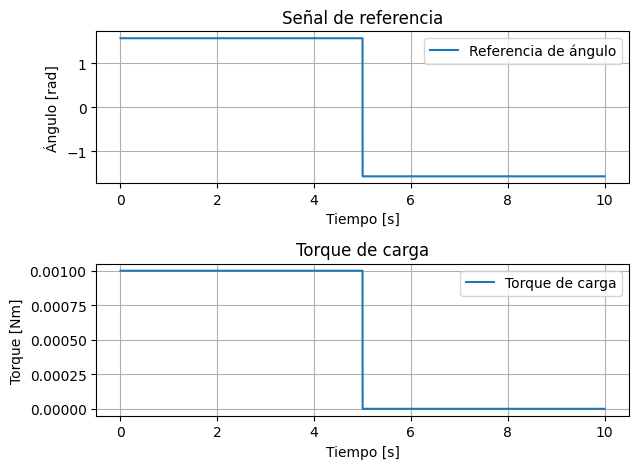

In [ ]:
#Definir Torque de entrada y Senal de referencia
# Definir la duración de la simulación
t_final = 10  # segundos
t_step = dt  # paso de tiempo para la simulación
t = np.arange(0, t_final, t_step)

# Definir la señal de referencia
ref_signal = np.piecewise(t, [t < 5, (t >= 5) & (t < 10), (t >= 10) & (t < 15), t >= 15],
                          [np.pi/2, -np.pi/2, np.pi/2, -np.pi/2])

# Definir el torque de carga TL como una señal simple (por ejemplo, un seno)
TL = np.piecewise(t, [t < 5, (t >= 5) & (t < 10), (t >= 10) & (t < 15), t >= 15],
                  [0.001, 0, 0.001, 0])

# Graficar la señal de referencia y el torque de carga
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, ref_signal, label='Referencia de ángulo')
plt.title('Señal de referencia')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, TL, label='Torque de carga')
plt.title('Torque de carga')
plt.xlabel('Tiempo [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

<ipython-input-50-ff7806d5b13a>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[k] = np.clip(u, -24, 24)
<ipython-input-50-ff7806d5b13a>:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


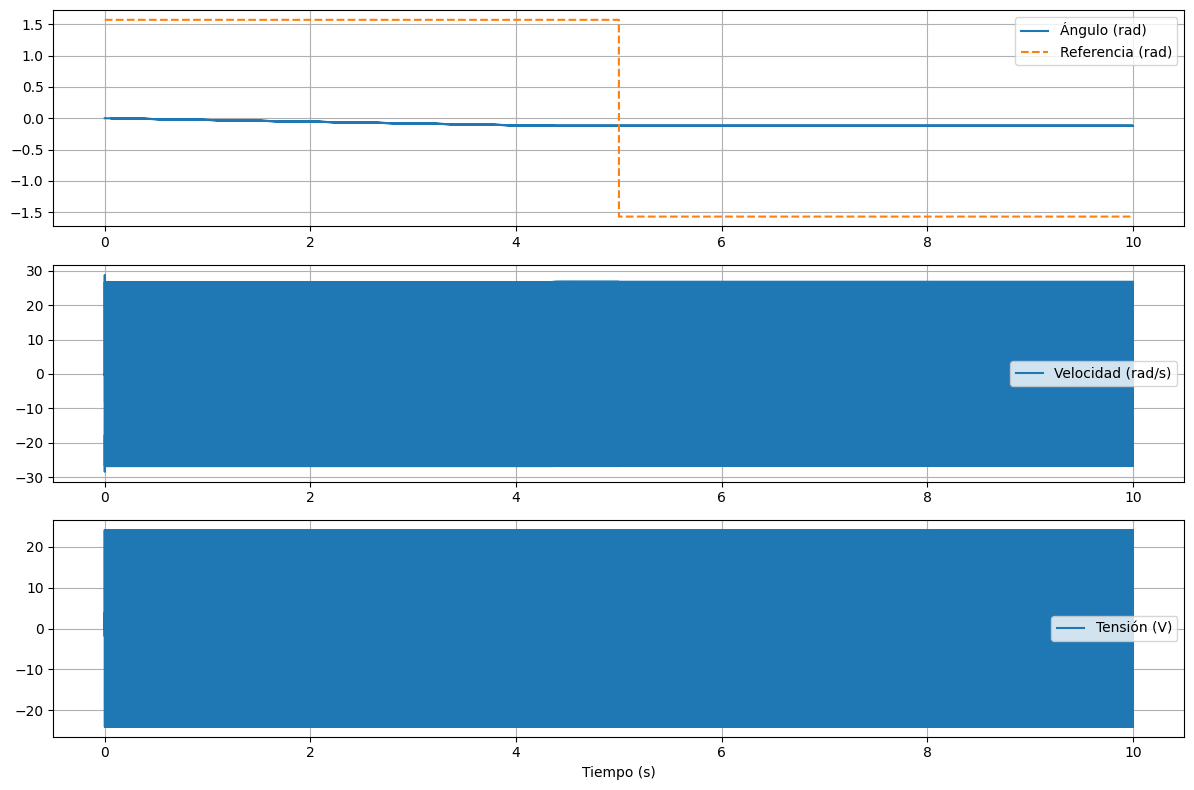

In [ ]:
# Inicialización de los estados
theta = np.zeros(len(t))
omega = np.zeros(len(t))
i = np.zeros(len(t))
V = np.zeros(len(t))

# Simulación del sistema con el controlador LQR
for k in range(1, len(t)):
    # Estado del sistema
    x = np.array([theta[k-1], omega[k-1], i[k-1]])

    # Error
    e = ref_signal[k] - theta[k-1]

    # Controlador LQR
    u = -np.dot(K, x)

    # Limitar la tensión a ±24V
    V[k] = np.clip(u, -24, 24)

    # Ecuaciones de estado (método de Euler)
    theta[k] = theta[k-1] + dt * omega[k-1]
    omega[k] = omega[k-1] + dt * (Ki * i[k-1] - Bm * omega[k-1] - TL[k-1]) / J
    i[k] = i[k-1] + dt * (V[k] - Ra * i[k-1] - Km * omega[k-1]) / Laa

# Graficar los resultados
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t, theta, label='Ángulo (rad)')
plt.plot(t, ref_signal, '--', label='Referencia (rad)')
plt.legend()
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(t, omega, label='Velocidad (rad/s)')
plt.legend()
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(t, V, label='Tensión (V)')
plt.legend()
plt.xlabel('Tiempo (s)')
plt.grid()
plt.tight_layout()
plt.show()